# Clustering Algorithm Test

In [9]:
%matplotlib inline
import wntr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.metrics.cluster import davies_bouldin_score
from sklearn.metrics.cluster import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import os
import sys
sys.path.append(".../master_thesis_code/")

from WaterNetWorkBasics import WaterNetWorkBasics as wnb

# Get C-Town Information

We load the .inp file within the user defined class testWN and populate:

WaterNetWorkBasics.wn = wntr.network.WaterNetworkModel(self.__filePath)

The class adds some convenience methods or properties that act directly on the network, such as:

ctown.name_list = {"node_name_list":[...], "link_name_list":[...], "control_name_list": [...], "pattern_name_list": [...] }

These names are used throughout this script.

In [8]:
ctown = wnb("c-town_true_network.inp", "c_town")

## Data Preprocessing

### Pressure data

In [2]:
X = pd.read_csv("pressure_0_epanet_whole.csv")
temp_list = list(X.keys())
time_list = X.values[:,0]
junction_name_list = [j for j in temp_list if j.startswith("J")]

X_pressure = X[junction_name_list].values

In [3]:
X_pressure

array([[29.965738, 65.43215 , 34.590523, ..., 20.774162, 68.69616 ,
        68.69616 ],
       [30.378782, 65.563416, 34.82874 , ..., 21.129118, 69.87931 ,
        69.87931 ],
       [30.982485, 65.574036, 34.977665, ..., 21.532223, 74.7451  ,
        74.7451  ],
       ...,
       [30.126715, 61.17526 , 33.714306, ..., 16.718918, 65.73825 ,
        65.73825 ],
       [29.812092, 63.57974 , 34.829273, ..., 18.44376 , 66.24489 ,
        66.24489 ],
       [29.778093, 63.98687 , 35.003693, ..., 19.257483, 68.09147 ,
        68.09147 ]])

In [4]:
X_pressure.shape

(169, 388)

In [5]:
time_list

array([     0.,   3600.,   7200.,  10800.,  14400.,  18000.,  21600.,
        25200.,  28800.,  32400.,  36000.,  39600.,  43200.,  46800.,
        50400.,  54000.,  57600.,  61200.,  64800.,  68400.,  72000.,
        75600.,  79200.,  82800.,  86400.,  90000.,  93600.,  97200.,
       100800., 104400., 108000., 111600., 115200., 118800., 122400.,
       126000., 129600., 133200., 136800., 140400., 144000., 147600.,
       151200., 154800., 158400., 162000., 165600., 169200., 172800.,
       176400., 180000., 183600., 187200., 190800., 194400., 198000.,
       201600., 205200., 208800., 212400., 216000., 219600., 223200.,
       226800., 230400., 234000., 237600., 241200., 244800., 248400.,
       252000., 255600., 259200., 262800., 266400., 270000., 273600.,
       277200., 280800., 284400., 288000., 291600., 295200., 298800.,
       302400., 306000., 309600., 313200., 316800., 320400., 324000.,
       327600., 331200., 334800., 338400., 342000., 345600., 349200.,
       352800., 3564

### Get Data Normalized and Visualization

In [6]:
def data_normalization(data):
    scaling_factor = np.mean(data, axis = 0).reshape(-1,1)
    normalized_data = np.zeros(data.shape)
    for i in range(data.shape[1]):
        normalized_data[:,i] = data[:,i]/scaling_factor[i]
    return normalized_data

X_pressure_normalized = data_normalization(X_pressure)

In [7]:
X_pressure_normalized

array([[0.9670408 , 0.98888124, 0.90222462, ..., 0.85148256, 1.01049516,
        1.01049516],
       [0.98037037, 0.99086507, 0.90843803, ..., 0.86603135, 1.02789886,
        1.02789886],
       [0.9998528 , 0.99102557, 0.91232244, ..., 0.88255364, 1.09947284,
        1.09947284],
       ...,
       [0.97223577, 0.92454652, 0.87937025, ..., 0.68526794, 0.9669854 ,
        0.9669854 ],
       [0.9620824 , 0.96088562, 0.90845193, ..., 0.75596503, 0.97443788,
        0.97443788],
       [0.9609852 , 0.96703861, 0.91300133, ..., 0.78931756, 1.00160039,
        1.00160039]])

In [8]:
X_pressure

array([[29.965738, 65.43215 , 34.590523, ..., 20.774162, 68.69616 ,
        68.69616 ],
       [30.378782, 65.563416, 34.82874 , ..., 21.129118, 69.87931 ,
        69.87931 ],
       [30.982485, 65.574036, 34.977665, ..., 21.532223, 74.7451  ,
        74.7451  ],
       ...,
       [30.126715, 61.17526 , 33.714306, ..., 16.718918, 65.73825 ,
        65.73825 ],
       [29.812092, 63.57974 , 34.829273, ..., 18.44376 , 66.24489 ,
        66.24489 ],
       [29.778093, 63.98687 , 35.003693, ..., 19.257483, 68.09147 ,
        68.09147 ]])

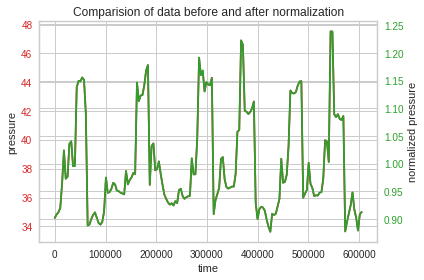

In [9]:
fig, ax1 = plt.subplots()

color = "tab:red"
plt.title("Comparision of data before and after normalization")
ax1.plot(time_list, X_pressure[:,2],color = color, label = "original data")
ax1.set_xlabel("time")
ax1.set_ylabel("pressure")
ax1.tick_params(axis="y", labelcolor = color)

ax2 = ax1.twinx()

color = "tab:green"
ax2.set_ylabel("normalized pressure")
ax2.plot(time_list, X_pressure_normalized[:,2],color=color, label = "normalized data")
ax2.tick_params(axis="y", labelcolor = color)

fig.tight_layout()
plt.show()

### Scaling Data

In [10]:
mms = MinMaxScaler()
ss = StandardScaler()
X_pressure_mms = mms.fit_transform(X_pressure)
X_pressure_ss = ss.fit_transform(X_pressure)

In [11]:
X_pressure_mms

array([[0.26081904, 0.36284516, 0.06938196, ..., 0.21996324, 0.63214482,
        0.63214482],
       [0.40372832, 0.3740339 , 0.08657054, ..., 0.23921665, 0.68579995,
        0.68579995],
       [0.61260381, 0.37493912, 0.09731623, ..., 0.26108174, 0.90646054,
        0.90646054],
       ...,
       [0.31651554, 0.        , 0.00615844, ..., 0.        , 0.49800542,
        0.49800542],
       [0.20765898, 0.20495102, 0.08660899, ..., 0.09355832, 0.52098123,
        0.52098123],
       [0.19589565, 0.23965362, 0.09919429, ..., 0.13769602, 0.6047225 ,
        0.6047225 ]])

In [12]:
X_pressure_ss

array([[-1.69381039, -0.31355548, -1.07137823, ..., -0.82426179,
         0.14184081,  0.14184081],
       [-1.00878889, -0.25761025, -1.00329446, ..., -0.74351701,
         0.37704968,  0.37704968],
       [-0.00756495, -0.25308403, -0.96073085, ..., -0.65181937,
         1.34436317,  1.34436317],
       ...,
       [-1.4268347 , -2.12783127, -1.32180602, ..., -1.74674178,
        -0.44618831, -0.44618831],
       [-1.94862783, -1.10304796, -1.00314212, ..., -1.35437766,
        -0.34546886, -0.34546886],
       [-2.00501419, -0.92953018, -0.9532919 , ..., -1.16927334,
         0.02162913,  0.02162913]])

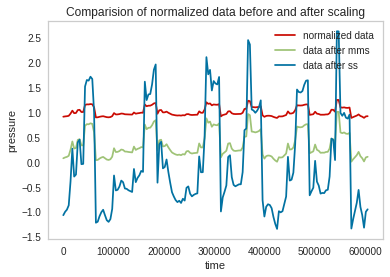

In [13]:
plt.figure()
plt.title("Comparision of normalized data before and after scaling")
plt.plot(time_list, X_pressure_normalized[:,2],"r-", label = "normalized data")
plt.plot(time_list, X_pressure_mms[:,2],"g-", label = "data after mms")
plt.plot(time_list, X_pressure_ss[:,2],"b-", label = "data after ss")
plt.xlabel("time")
plt.ylabel("pressure")
plt.legend(loc = "best")
plt.grid()
fig.tight_layout()
plt.show()

### PCA

In [14]:
pca = PCA().fit(X_pressure_ss.T)
variance = pca.explained_variance_ratio_
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

Plot the explained variance

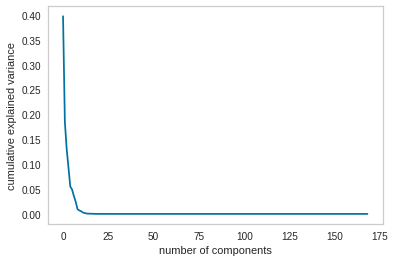

In [15]:
plt.figure()
plt.plot(variance)
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.grid()
plt.show()

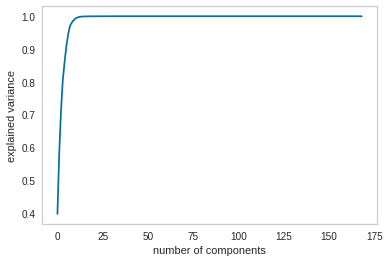

In [16]:
plt.figure()
plt.plot(cumsum_variance)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.grid()
plt.show()

Find the optimal n_components.

In [17]:
pca = PCA(0.99).fit(X_pressure_ss.T)
n_components = pca.n_components_
n_components

11

Use n_components = 11 to get the reduce X_pressure data

In [18]:
X_pressure_ss_reduced = pca.transform(X_pressure_ss.T)

In [19]:
X_pressure_ss_reduced.shape 

(388, 11)

After we reduce the dimension the data has the shape of (388, 11) and now we can implement the clustering method on this data set. This is also the reason of PCA, simplifying the data set by extracting the most important features in order to accelerate the clustering efficiency.

# Clustering Method

## KMeans

In [20]:
# define a result dictionary
# KMeans_dict = {"n_component":[KMeans.labels_]}

KMeans_dict = dict()

# define a list to store the sum 
# of squared distances of samples to their closest cluster center.
sum_of_squared_distances = []

# define a list to store the different clusters
n_cluster_list = np.arange(2,101)

In [21]:
# models
models = [KMeans(n_clusters=n_cluster) for n_cluster in n_cluster_list]

# result
result_labels = [model.fit(X_pressure_normalized.T).labels_ for model in models]

In [22]:
# evaluate the result
silhouette_score = [silhouette_score(X_pressure_normalized.T, label) for label in result_labels]
davies_score = [davies_bouldin_score(X_pressure_normalized.T, label) for label in result_labels]
calinski_score = [calinski_harabasz_score(X_pressure_normalized.T, label) for label in result_labels]

Plot the result

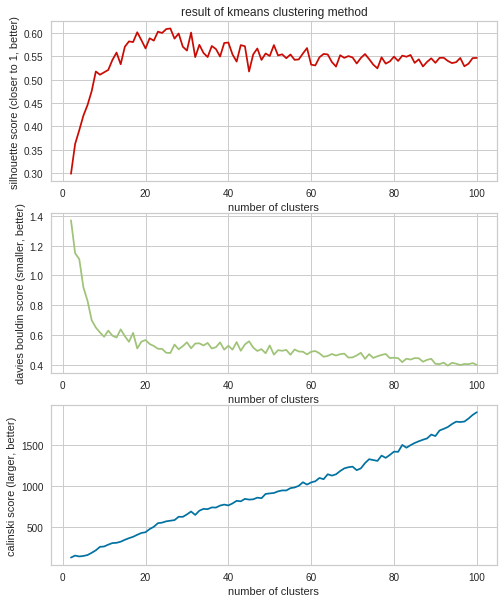

In [29]:
# plot the result
plt.figure(figsize=(8,10))

plt.subplot(311)
plt.title("result of kmeans clustering method")
plt.plot(n_cluster_list, silhouette_score, "r-", label = "silhouette score")
plt.xlabel("number of clusters")
plt.ylabel("silhouette score (closer to 1, better)")
plt.grid(True)

plt.subplot(312)
plt.plot(n_cluster_list, davies_score, "g-", label = "davies_bouldin_score")
plt.xlabel("number of clusters")
plt.ylabel("davies bouldin score (smaller, better)")
plt.grid(True)

plt.subplot(313)
plt.plot(n_cluster_list, calinski_score, "b-", label = "calinski_harabasz_score")
plt.xlabel("number of clusters")
plt.ylabel("calinski score (larger, better)")
plt.grid(True)

fig.tight_layout()
plt.show()

### Visualization

KElbowVisualizer

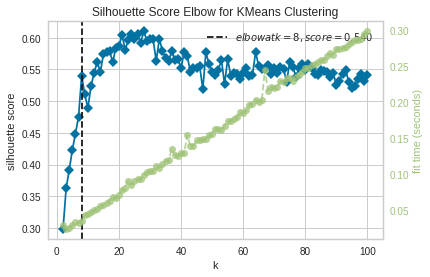

In [24]:
model = KMeans()
visualizer_silhouette = KElbowVisualizer(model, k=(2,101), metric="silhouette")
visualizer_silhouette.fit(X_pressure_normalized.T)
visualizer_silhouette.show()

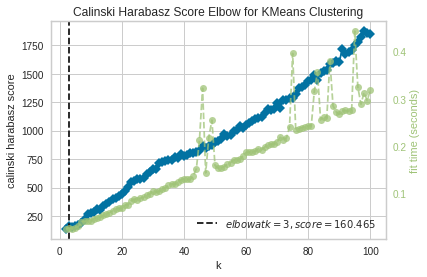

In [25]:
visualizer_calinski = KElbowVisualizer(model, k=(2,101), metric="calinski_harabasz")
visualizer_calinski.fit(X_pressure_normalized.T)
visualizer_calinski.show()

The scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center

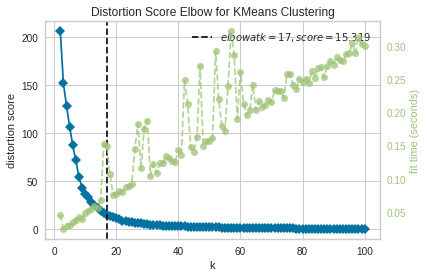

In [26]:
visualizer_distortion = KElbowVisualizer(model, k=(2,101))
visualizer_distortion.fit(X_pressure_normalized.T)
visualizer_distortion.show()

Silhouette Visualizer

In [27]:
silhouette_visualizer = [SilhouetteVisualizer(KMeans(n_clusters=n_cluster), colors='yellowbrick') for n_cluster in n_cluster_list]

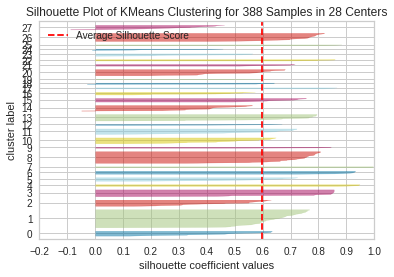

In [33]:
silhouette_visualizer_26 = silhouette_visualizer[26].fit(X_pressure_normalized.T)
silhouette_visualizer_26.show()

Plot the cluster result in c_town map

## Agglomerative

### Connectivity Matrix

### Visualization

## DBSCAN

### Visualization

## Spectral Clustering

### Visualization

## Gaussian Mixture Model

### Visualization

# Comparision of Result among different Methods